<a href="https://colab.research.google.com/github/vshalisko/GEE/blob/main/Colab/Landsat_ANN_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pyrsgis

In [3]:
import ee
import geemap
from google.colab import drive
import math, random, glob, time
random.seed(2)
import numpy as np
from pyrsgis import raster

Uso de ANN para clasificacion de Landsat

In [4]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-viacheslavs')

Lectura de capas de datos

In [5]:
punto_interes = ee.Geometry.Point([-103.76, 19.75])
print(punto_interes.getInfo())

L8_collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(punto_interes).filterDate('2015-03-01', '2015-05-15')
print(L8_collection.size().getInfo())

# Load an image (Landsat 8).
L8_image = L8_collection.first()

# Load builtup 2015 (res 100 m)
ghs_built_image = ee.Image('JRC/GHSL/P2023A/GHS_BUILT_S/2015')
built_2015_lr = ghs_built_image.select('built_surface')

# Load builtup 2015 (res 10 m)
built_2015_hr = ee.Image('DLR/WSF/WSF2015/v1')

# blackBackground = ee.Image(0);


{'type': 'Point', 'coordinates': [-103.76, 19.75]}
4


Visualizar

In [6]:

Map = geemap.Map()
# Center the map and display the image.
Map.centerObject(punto_interes, 8)

# Define the visualization parameters L8
vizParams_L8 = {
  'bands': ['SR_B5', 'SR_B4', 'SR_B3'],
   'min': 5000,
   'max': 15000
  #'gamma': [0.95, 1.1, 1]
}
# Define the visualization parameters Builtup LR
vizBuiltup_LR = {
   'min': 0,
   'max': 1,
  'palette': ['white','black']
}
# Define the visualization parameters Builtup HR
vizBuiltup_HR = {
  min: 0,
  max: 255,
  'palette': ['white','black']
}

# Add layers
Map.addLayer(L8_image, vizParams_L8, 'Composición de falso color', True, 0.5)
Map.addLayer(built_2015_lr, vizBuiltup_LR, 'Builtup 2015 100m', True, 0.5)
Map.addLayer(built_2015_hr, vizBuiltup_HR, 'Builtup 2015 10m', True, 0.5)

# Display the map
Map


Map(center=[19.75, -103.76], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

Pruebas para convertir a numpy

None
{'type': 'Projection', 'crs': 'EPSG:32613', 'transform': [30, 0, 552285, 0, -30, 2352915]}
First array (102, 124, 6)
Second array (102, 125, 6)
Full array (102, 249, 6)


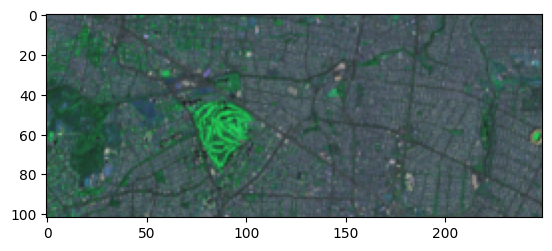

In [29]:
bands_L8 = ['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']
bands_B = ['settelment']

def tile_to_numpy(image, rectangle, bands):
  ## extraccion de bandas en un region rectangular
  image_tile = image.sampleRectangle(region=rectangle)
  first_band = image_tile.get(bands[0])
  band_array_np = np.array(first_band.getInfo())
  band_array_np = np.expand_dims(band_array_np, 2)
  for b in bands[1:]:
    b_arr = image_tile.get(b)
    b_arr_np = np.array(b_arr.getInfo())
    b_arr_np = np.expand_dims(b_arr_np, 2)
    #print(b_arr_np.shape)
    #print(band_array_np.shape)
    band_array_np = np.concatenate((band_array_np, b_arr_np), 2)
  return band_array_np



image_meta = L8_image.getInfo()
imagename = image_meta.get('properties',{}).get('PRODUCT_ID')
print(imagename)

projection = L8_image.projection().getInfo();
print(projection)

#print(geemap.image_props(image).getInfo())

# definición de un region pequeño para el analisis
aoi1 = ee.Geometry.Polygon(
        [[[-103.39846006557397, 20.721686475573005],
          [-103.39846006557397, 20.694710560279958],
          [-103.36309782192163, 20.694710560279958],
          [-103.36309782192163, 20.721686475573005]]], None, False);
aoi2 = ee.Geometry.Polygon(
        [[[-103.36309782192163, 20.721686475573005],
          [-103.36309782192163, 20.694710560279958],
          [-103.32773557826929, 20.694710560279958],
          [-103.32773557826929, 20.721686475573005]]], None, False);


array1 = tile_to_numpy(L8_image, aoi1, bands_L8)
print("First array", array1.shape)
array2 = tile_to_numpy(L8_image, aoi2, bands_L8)
print("Second array", array2.shape)


array_full = np.concatenate((array1, array2), 1)
print("Full array", array_full.shape)

import matplotlib.pyplot as plt

# Scale the data to [0, 255] to show as an RGB image.
rgb_img_test = (255*((array_full - 5000)/30000)).astype('uint8')
plt.imshow(rgb_img_test[:,:,2:5])
plt.show()



In [40]:
def loadTiff(in_image, init=None, size_img=None):
    src = raster.read(in_image, bands='all')
    nbands = src.RasterCount
    in_band = src.GetRasterBand(1)  # load one band for size reference
    if init is None:
        xinit,yinit = (0, 0)
    else:
        xinit,yinit = init
    if size_img is None:
        block_xsize, block_ysize = (in_band.XSize, in_band.YSize)
    else:
        block_xsize, block_ysize = size_img

    # read the (multiband) file into an array
    image = src.ReadAsArray(xinit, yinit, block_xsize, block_ysize)
    # reshape from bandsxheightxwidth to wxhxb
    image = np.moveaxis(image, 0, -1)
    return image, block_ysize, block_xsize, nbands

#[img, xsize, ysize, nbands] = loadTiff(os.path.join(drive,image))

In [41]:
#task_config = {
#    'image': image,
#    'fileFormat': 'GeoTIFF',
#    'folder': 'test_L8_image',
#    'fileNamePrefix': imagename[0:19],
#    'crs': projection,
#    'crsTransform': projection.transform,
#    'description': "clipped area",
#    'scale':20,
#    'region':poly_area
#}


# This is how we order it to start
#task = ee.batch.Export.image.toDrive(**task_config )
#task.start()

### check task status - you can see if it failed, it's running or finished
#task.status()

In [42]:
#drive = "/content/drive/MyDrive/exercise/"

### loading the file
#s2_data = "test_L8_image"

### loading and checking
#ds1, bands = raster.read(s2_data)
#print(ds1)
#print(bands.shape)